# SAM3 Zero-Shot Medical Image Segmentation Visualization

This notebook visualizes SAM3's zero-shot segmentation performance on 5 medical image datasets:
- **CHASE_DB1** - Fundus (Retinal Vessel Segmentation)
- **STARE** - Fundus (Retinal Vessel Segmentation)
- **CVC-ClinicDB** - Endoscopy (Polyp Segmentation)
- **ETIS-Larib** - Endoscopy (Polyp Detection)
- **PH2** - Dermoscopy (Skin Lesion Segmentation)

For each dataset, we show:
1. Input image
2. Ground truth mask
3. Box prompt prediction
4. Text prompt prediction (zero-shot)

Metrics: Dice, IoU, PSNR, SSIM

## 1. Setup and Imports

In [1]:
import sys
import json
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Set paths
INFERENCE_DIR = Path("/home/jtu9/SAM/medsam/inference")
sys.path.insert(0, str(INFERENCE_DIR))

# Import local modules
from dataset_loaders import load_dataset, DATASET_LOADERS, DATASET_PROMPTS
from sam3_inference import SAM3Model, generate_bbox_from_mask, resize_mask
from metrics import compute_all_metrics

# Set random seed for reproducibility
random.seed(42)

print("Setup complete!")
print(f"Available datasets: {list(DATASET_LOADERS.keys())}")

Setup complete!
Available datasets: ['CHASE_DB1', 'STARE', 'CVC-ClinicDB', 'ETIS-Larib', 'PH2']


## 2. Load Evaluation Results

In [2]:
# Load pre-computed evaluation results
results_path = INFERENCE_DIR / "results" / "sam3_evaluation_detailed.json"

with open(results_path, 'r') as f:
    eval_results = json.load(f)

# Display summary
print("\n" + "="*70)
print("SAM3 Zero-Shot Evaluation Summary")
print("="*70)

summary_data = []
for r in eval_results:
    summary_data.append({
        'Dataset': r['dataset'],
        'Text Prompt': r['text_prompt'],
        'Box Dice': f"{r['box_prompt']['dice']*100:.1f}%",
        'Box IoU': f"{r['box_prompt']['iou']*100:.1f}%",
        'Box SSIM': f"{r['box_prompt']['ssim']:.3f}",
        'Text Dice': f"{r['text_prompt_results']['dice']*100:.1f}%",
        'Samples': r['box_prompt']['n_samples']
    })

df_summary = pd.DataFrame(summary_data)
display(df_summary)


SAM3 Zero-Shot Evaluation Summary


,Dataset,Text Prompt,Box Dice,Box IoU,Box SSIM,Text Dice,Samples
0,CHASE_DB1,Retinal Blood Vessel,8.2%,4.5%,0.008,17.9%,28
1,STARE,Retinal Blood Vessel,19.5%,10.9%,0.044,18.6%,20
2,CVC-ClinicDB,Polyp,93.6%,88.6%,0.926,0.0%,612
3,ETIS-Larib,Polyp,94.4%,89.7%,0.943,0.0%,196
4,PH2,Skin Lesion,93.9%,89.7%,0.896,18.4%,200


## 3. Visualization Functions

In [3]:
def visualize_sample(image, gt_mask, pred_box, pred_text, 
                     metrics_box, metrics_text, dataset_name, sample_id, text_prompt):
    """
    Visualize a sample with input, GT, and predictions.
    
    Shows 4 images side by side:
    1. Input image with bounding box overlay
    2. Ground truth mask
    3. Box prompt prediction
    4. Text prompt prediction
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Input image with bbox
    axes[0].imshow(image)
    bbox = generate_bbox_from_mask(gt_mask)
    if bbox:
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              fill=False, edgecolor='lime', linewidth=2)
        axes[0].add_patch(rect)
    axes[0].set_title(f"Input Image\n({image.shape[1]}x{image.shape[0]})", fontsize=12)
    axes[0].axis('off')
    
    # 2. Ground Truth
    axes[1].imshow(gt_mask, cmap='gray')
    gt_pixels = gt_mask.sum()
    axes[1].set_title(f"Ground Truth\n({gt_pixels:,} pixels)", fontsize=12)
    axes[1].axis('off')
    
    # 3. Box Prompt Prediction
    if pred_box is not None:
        axes[2].imshow(pred_box, cmap='gray')
        title = (f"Box Prompt\n"
                f"Dice: {metrics_box.dice:.2%} | IoU: {metrics_box.iou:.2%}\n"
                f"PSNR: {metrics_box.psnr:.1f}dB | SSIM: {metrics_box.ssim:.3f}")
    else:
        axes[2].imshow(np.zeros_like(gt_mask), cmap='gray')
        title = "Box Prompt\nNo prediction"
    axes[2].set_title(title, fontsize=10)
    axes[2].axis('off')
    
    # 4. Text Prompt Prediction
    if pred_text is not None and pred_text.sum() > 0:
        axes[3].imshow(pred_text, cmap='gray')
        title = (f"Text Prompt: \"{text_prompt}\"\n"
                f"Dice: {metrics_text.dice:.2%} | IoU: {metrics_text.iou:.2%}\n"
                f"PSNR: {metrics_text.psnr:.1f}dB | SSIM: {metrics_text.ssim:.3f}")
    else:
        axes[3].imshow(np.zeros_like(gt_mask), cmap='gray')
        title = f"Text Prompt: \"{text_prompt}\"\nNo prediction"
    axes[3].set_title(title, fontsize=10)
    axes[3].axis('off')
    
    plt.suptitle(f"{dataset_name} - Sample: {sample_id}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def create_overlay(image, mask, color=(0, 255, 0), alpha=0.4):
    """Create an overlay of mask on image."""
    overlay = image.copy()
    mask_bool = mask.astype(bool)
    for c in range(3):
        overlay[:, :, c] = np.where(
            mask_bool,
            overlay[:, :, c] * (1 - alpha) + color[c] * alpha,
            overlay[:, :, c]
        )
    return overlay.astype(np.uint8)

print("Visualization functions defined!")

Visualization functions defined!


## 4. Load SAM3 Model

In [4]:
# Initialize SAM3 model
print("Loading SAM3 model...")
sam3 = SAM3Model(confidence_threshold=0.1)
sam3.load_model()
print("SAM3 model loaded successfully!")

Loading SAM3 model...
Loading SAM3 model...
SAM3 model loaded successfully!
SAM3 model loaded successfully!


## 5. CHASE_DB1 - Retinal Vessel Segmentation

Dataset: CHASE_DB1
Sample: Image_11L
Image shape: (960, 999, 3)
Text prompt: Retinal Blood Vessel


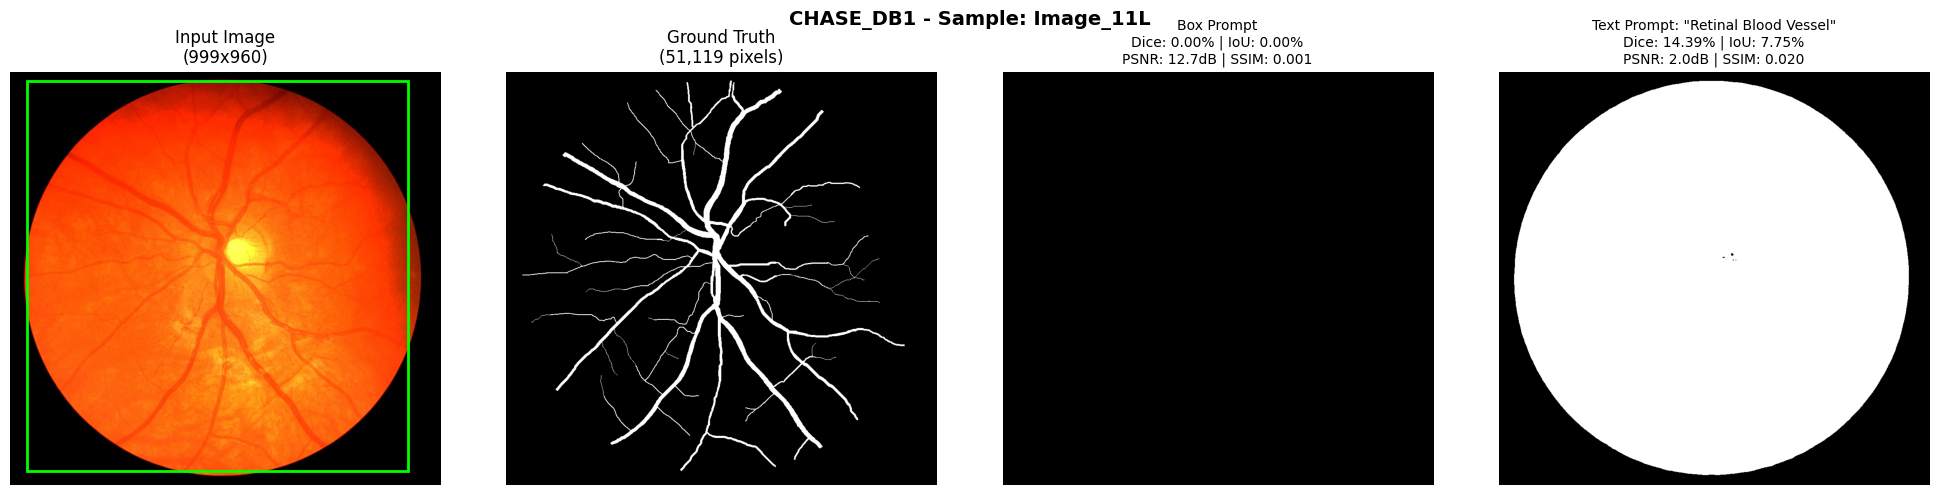

In [5]:
# Load random sample from CHASE_DB1
dataset_name = "CHASE_DB1"
samples = list(load_dataset(dataset_name))
sample = random.choice(samples)

print(f"Dataset: {dataset_name}")
print(f"Sample: {sample.sample_id}")
print(f"Image shape: {sample.image.shape}")
print(f"Text prompt: {sample.text_prompt}")

# Encode image
inference_state = sam3.encode_image(sample.image)

# Generate bbox from GT
bbox = generate_bbox_from_mask(sample.gt_mask)
img_size = sample.gt_mask.shape

# Box prompt inference
pred_box = sam3.predict_box(inference_state, bbox, img_size)
if pred_box is not None and pred_box.shape != img_size:
    pred_box = resize_mask(pred_box, img_size)

# Text prompt inference
pred_text = sam3.predict_text(inference_state, sample.text_prompt)
if pred_text is not None and pred_text.shape != img_size:
    pred_text = resize_mask(pred_text, img_size)

# Compute metrics
metrics_box = compute_all_metrics(pred_box if pred_box is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)
metrics_text = compute_all_metrics(pred_text if pred_text is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)

# Visualize
visualize_sample(sample.image, sample.gt_mask, pred_box, pred_text,
                 metrics_box, metrics_text, dataset_name, sample.sample_id, sample.text_prompt)

## 6. STARE - Retinal Vessel Segmentation

Dataset: STARE
Sample: im0004
Image shape: (605, 700, 3)
Text prompt: Retinal Blood Vessel


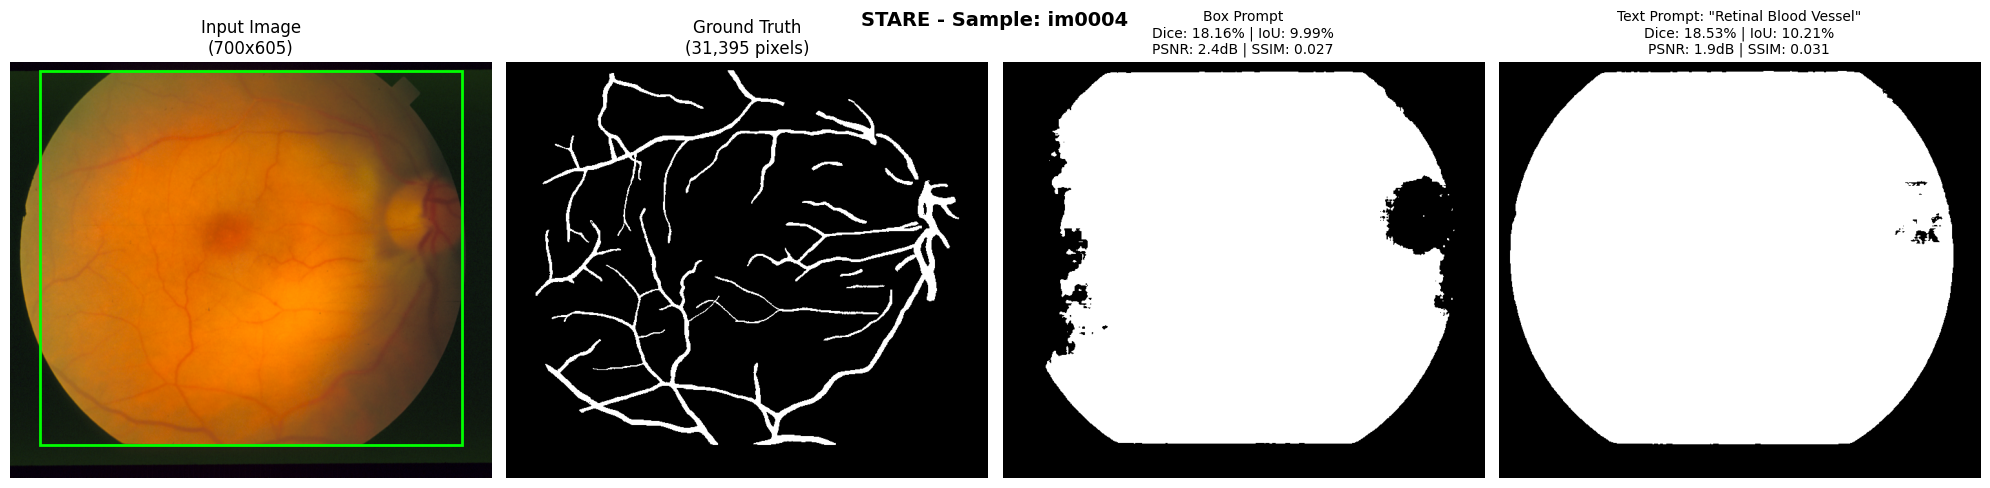

In [6]:
# Load random sample from STARE
dataset_name = "STARE"
samples = list(load_dataset(dataset_name))
sample = random.choice(samples)

print(f"Dataset: {dataset_name}")
print(f"Sample: {sample.sample_id}")
print(f"Image shape: {sample.image.shape}")
print(f"Text prompt: {sample.text_prompt}")

# Encode image
inference_state = sam3.encode_image(sample.image)

# Generate bbox from GT
bbox = generate_bbox_from_mask(sample.gt_mask)
img_size = sample.gt_mask.shape

# Box prompt inference
pred_box = sam3.predict_box(inference_state, bbox, img_size)
if pred_box is not None and pred_box.shape != img_size:
    pred_box = resize_mask(pred_box, img_size)

# Text prompt inference
pred_text = sam3.predict_text(inference_state, sample.text_prompt)
if pred_text is not None and pred_text.shape != img_size:
    pred_text = resize_mask(pred_text, img_size)

# Compute metrics
metrics_box = compute_all_metrics(pred_box if pred_box is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)
metrics_text = compute_all_metrics(pred_text if pred_text is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)

# Visualize
visualize_sample(sample.image, sample.gt_mask, pred_box, pred_text,
                 metrics_box, metrics_text, dataset_name, sample.sample_id, sample.text_prompt)

## 7. CVC-ClinicDB - Polyp Segmentation

Dataset: CVC-ClinicDB
Sample: 26
Image shape: (288, 384, 3)
Text prompt: Polyp


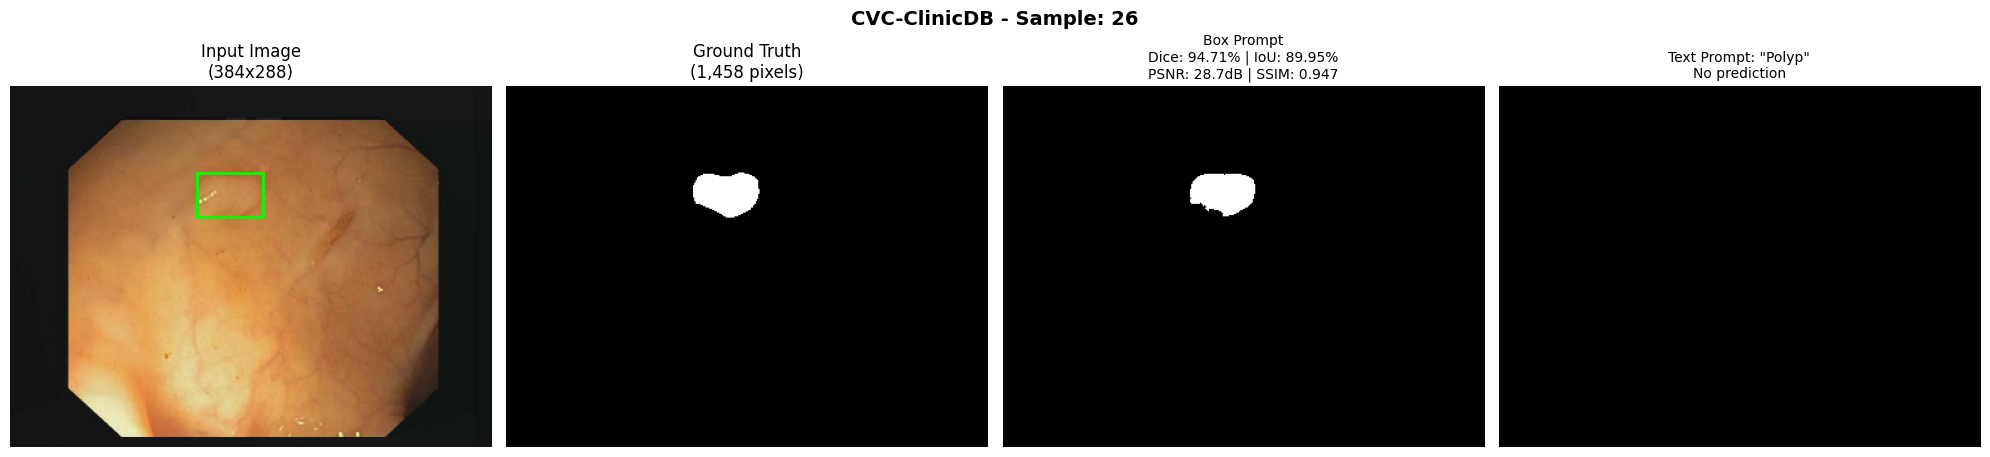

In [7]:
# Load random sample from CVC-ClinicDB
dataset_name = "CVC-ClinicDB"
samples = list(load_dataset(dataset_name))
sample = random.choice(samples)

print(f"Dataset: {dataset_name}")
print(f"Sample: {sample.sample_id}")
print(f"Image shape: {sample.image.shape}")
print(f"Text prompt: {sample.text_prompt}")

# Encode image
inference_state = sam3.encode_image(sample.image)

# Generate bbox from GT
bbox = generate_bbox_from_mask(sample.gt_mask)
img_size = sample.gt_mask.shape

# Box prompt inference
pred_box = sam3.predict_box(inference_state, bbox, img_size)
if pred_box is not None and pred_box.shape != img_size:
    pred_box = resize_mask(pred_box, img_size)

# Text prompt inference
pred_text = sam3.predict_text(inference_state, sample.text_prompt)
if pred_text is not None and pred_text.shape != img_size:
    pred_text = resize_mask(pred_text, img_size)

# Compute metrics
metrics_box = compute_all_metrics(pred_box if pred_box is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)
metrics_text = compute_all_metrics(pred_text if pred_text is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)

# Visualize
visualize_sample(sample.image, sample.gt_mask, pred_box, pred_text,
                 metrics_box, metrics_text, dataset_name, sample.sample_id, sample.text_prompt)

## 8. ETIS-Larib - Polyp Detection

Dataset: ETIS-Larib
Sample: 190
Image shape: (966, 1225, 3)
Text prompt: Polyp


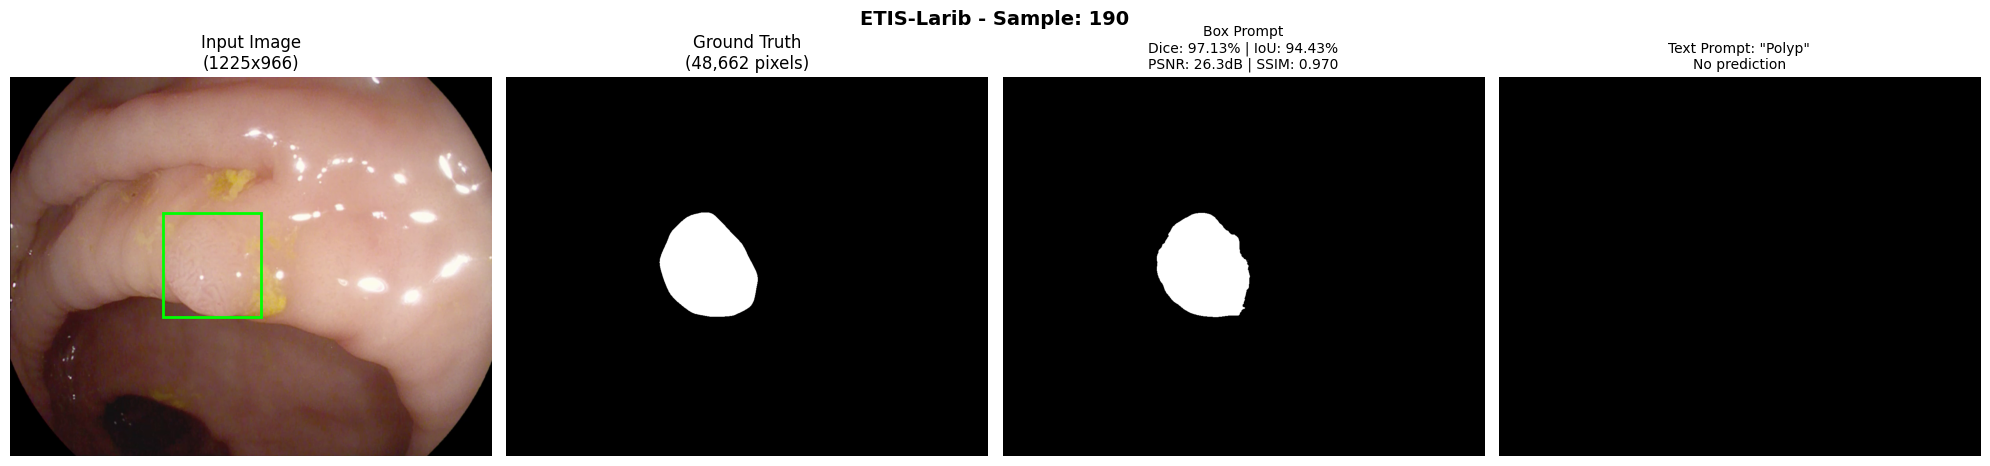

In [8]:
# Load random sample from ETIS-Larib
dataset_name = "ETIS-Larib"
samples = list(load_dataset(dataset_name))
sample = random.choice(samples)

print(f"Dataset: {dataset_name}")
print(f"Sample: {sample.sample_id}")
print(f"Image shape: {sample.image.shape}")
print(f"Text prompt: {sample.text_prompt}")

# Encode image
inference_state = sam3.encode_image(sample.image)

# Generate bbox from GT
bbox = generate_bbox_from_mask(sample.gt_mask)
img_size = sample.gt_mask.shape

# Box prompt inference
pred_box = sam3.predict_box(inference_state, bbox, img_size)
if pred_box is not None and pred_box.shape != img_size:
    pred_box = resize_mask(pred_box, img_size)

# Text prompt inference
pred_text = sam3.predict_text(inference_state, sample.text_prompt)
if pred_text is not None and pred_text.shape != img_size:
    pred_text = resize_mask(pred_text, img_size)

# Compute metrics
metrics_box = compute_all_metrics(pred_box if pred_box is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)
metrics_text = compute_all_metrics(pred_text if pred_text is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)

# Visualize
visualize_sample(sample.image, sample.gt_mask, pred_box, pred_text,
                 metrics_box, metrics_text, dataset_name, sample.sample_id, sample.text_prompt)

## 9. PH2 - Skin Lesion Segmentation

Dataset: PH2
Sample: IMD138
Image shape: (576, 767, 3)
Text prompt: Skin Lesion


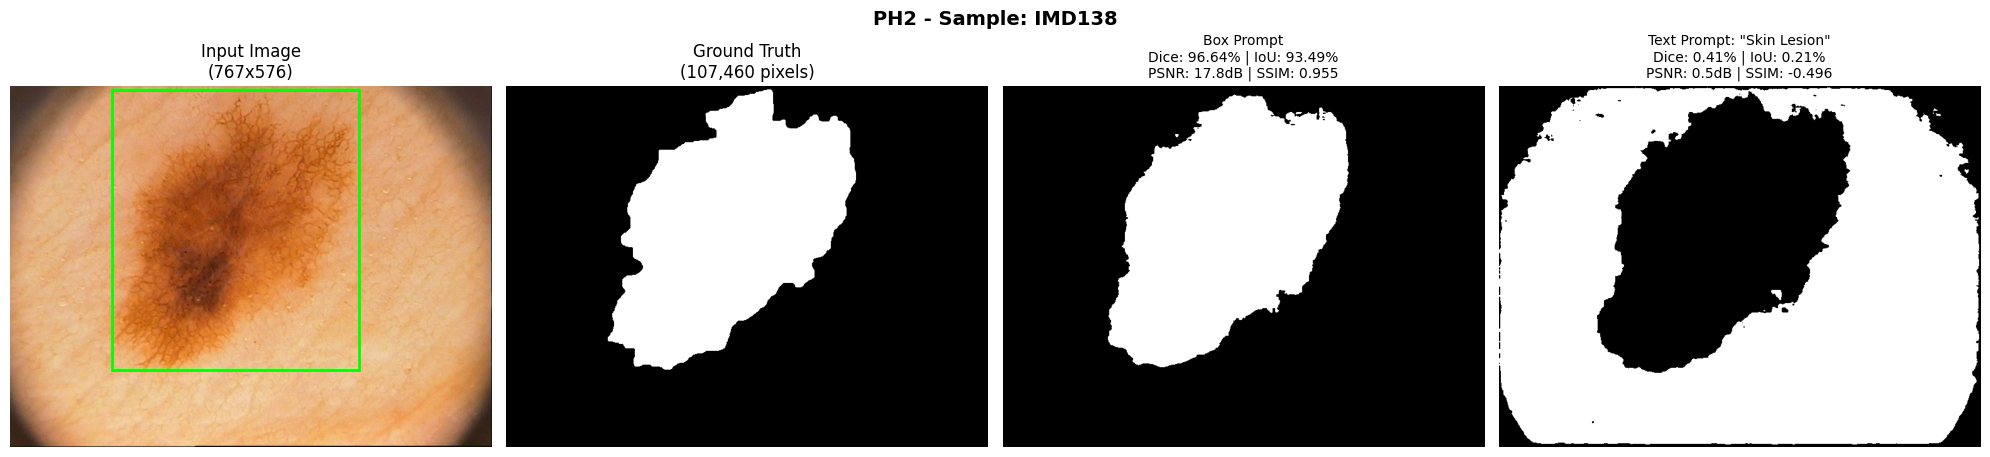

In [9]:
# Load random sample from PH2
dataset_name = "PH2"
samples = list(load_dataset(dataset_name))
sample = random.choice(samples)

print(f"Dataset: {dataset_name}")
print(f"Sample: {sample.sample_id}")
print(f"Image shape: {sample.image.shape}")
print(f"Text prompt: {sample.text_prompt}")

# Encode image
inference_state = sam3.encode_image(sample.image)

# Generate bbox from GT
bbox = generate_bbox_from_mask(sample.gt_mask)
img_size = sample.gt_mask.shape

# Box prompt inference
pred_box = sam3.predict_box(inference_state, bbox, img_size)
if pred_box is not None and pred_box.shape != img_size:
    pred_box = resize_mask(pred_box, img_size)

# Text prompt inference
pred_text = sam3.predict_text(inference_state, sample.text_prompt)
if pred_text is not None and pred_text.shape != img_size:
    pred_text = resize_mask(pred_text, img_size)

# Compute metrics
metrics_box = compute_all_metrics(pred_box if pred_box is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)
metrics_text = compute_all_metrics(pred_text if pred_text is not None else np.zeros_like(sample.gt_mask), sample.gt_mask)

# Visualize
visualize_sample(sample.image, sample.gt_mask, pred_box, pred_text,
                 metrics_box, metrics_text, dataset_name, sample.sample_id, sample.text_prompt)

## 10. Summary and Comparison

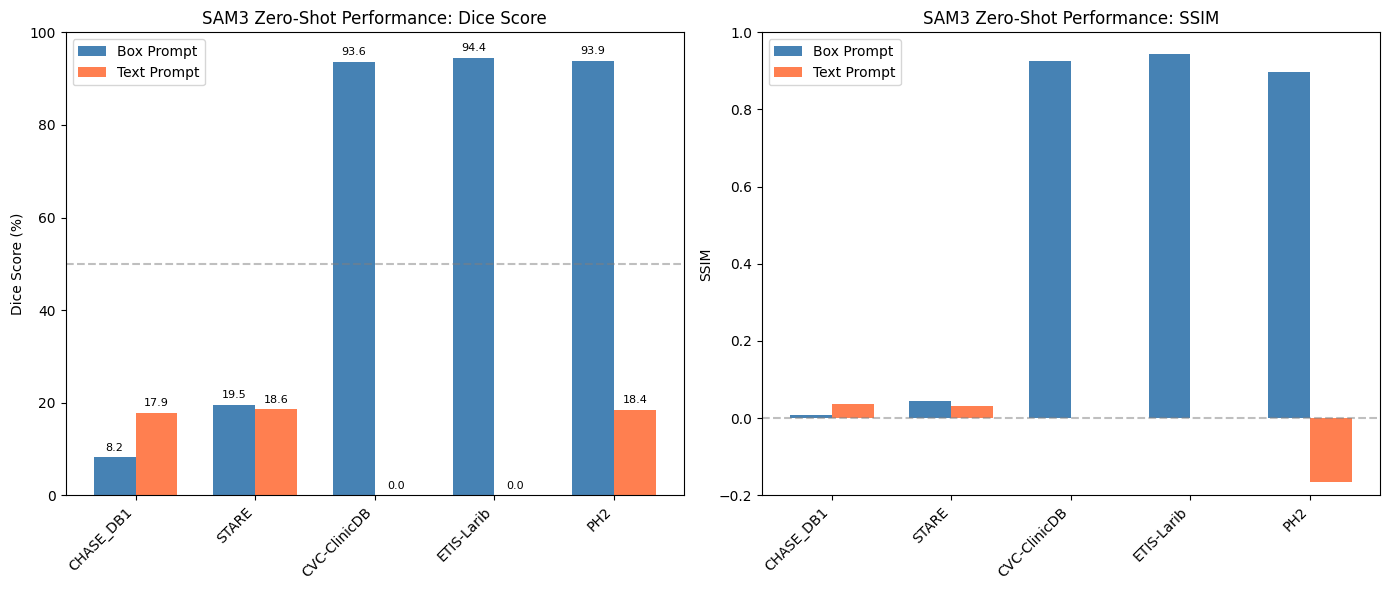


Figure saved to: results/sam3_performance_comparison.png


In [10]:
# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data
datasets = [r['dataset'] for r in eval_results]
box_dice = [r['box_prompt']['dice'] * 100 for r in eval_results]
text_dice = [r['text_prompt_results']['dice'] * 100 for r in eval_results]
box_ssim = [r['box_prompt']['ssim'] for r in eval_results]
text_ssim = [r['text_prompt_results']['ssim'] for r in eval_results]

x = np.arange(len(datasets))
width = 0.35

# Plot 1: Dice Score Comparison
bars1 = axes[0].bar(x - width/2, box_dice, width, label='Box Prompt', color='steelblue')
bars2 = axes[0].bar(x + width/2, text_dice, width, label='Text Prompt', color='coral')
axes[0].set_ylabel('Dice Score (%)')
axes[0].set_title('SAM3 Zero-Shot Performance: Dice Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 100)
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar, val in zip(bars1, box_dice):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, text_dice):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=8)

# Plot 2: SSIM Comparison
bars3 = axes[1].bar(x - width/2, box_ssim, width, label='Box Prompt', color='steelblue')
bars4 = axes[1].bar(x + width/2, text_ssim, width, label='Text Prompt', color='coral')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SAM3 Zero-Shot Performance: SSIM')
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(-0.2, 1.0)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(INFERENCE_DIR / 'results' / 'sam3_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: results/sam3_performance_comparison.png")

In [11]:
# Final summary table with all metrics
print("\n" + "="*80)
print("FINAL SUMMARY: SAM3 Zero-Shot Medical Image Segmentation")
print("="*80)

summary_full = []
for r in eval_results:
    summary_full.append({
        'Dataset': r['dataset'],
        'Modality': 'Fundus' if 'Vessel' in r['text_prompt'] else ('Endoscopy' if 'Polyp' in r['text_prompt'] else 'Dermoscopy'),
        'Prompt': r['text_prompt'],
        'Box Dice (%)': f"{r['box_prompt']['dice']*100:.1f}",
        'Box IoU (%)': f"{r['box_prompt']['iou']*100:.1f}",
        'Box PSNR (dB)': f"{r['box_prompt']['psnr']:.1f}",
        'Box SSIM': f"{r['box_prompt']['ssim']:.3f}",
        'Text Dice (%)': f"{r['text_prompt_results']['dice']*100:.1f}",
        'Text SSIM': f"{r['text_prompt_results']['ssim']:.3f}",
        'N': r['box_prompt']['n_samples']
    })

df_full = pd.DataFrame(summary_full)
display(df_full)

# Key findings
print("\n" + "-"*80)
print("KEY FINDINGS:")
print("-"*80)
print("1. Box Prompts work excellently for:")
print("   - Polyp segmentation (CVC-ClinicDB: 93.6%, ETIS-Larib: 94.4%)")
print("   - Skin lesion segmentation (PH2: 93.9%)")
print("\n2. Box Prompts struggle with:")
print("   - Retinal vessel segmentation (CHASE_DB1: 8.2%, STARE: 19.5%)")
print("   - This is expected as vessels are thin, branching structures")
print("\n3. Text Prompts:")
print("   - Work partially for retinal vessels (17-18% Dice)")
print("   - Fail completely for polyp detection (0% Dice)")
print("   - Work poorly for skin lesions (18% Dice)")
print("\n4. RECOMMENDATION:")
print("   - Use box prompts for medical image segmentation")
print("   - Text prompts are not reliable for zero-shot medical imaging")


FINAL SUMMARY: SAM3 Zero-Shot Medical Image Segmentation


,Dataset,Modality,Prompt,Box Dice (%),Box IoU (%),Box PSNR (dB),Box SSIM,Text Dice (%),Text SSIM,N
0,CHASE_DB1,Fundus,Retinal Blood Vessel,8.2,4.5,7.4,0.008,17.9,0.037,28
1,STARE,Fundus,Retinal Blood Vessel,19.5,10.9,2.5,0.044,18.6,0.031,20
2,CVC-ClinicDB,Endoscopy,Polyp,93.6,88.6,22.0,0.926,0.0,0.000,612
3,ETIS-Larib,Endoscopy,Polyp,94.4,89.7,26.9,0.943,0.0,0.000,196
4,PH2,Dermoscopy,Skin Lesion,93.9,89.7,16.7,0.896,18.4,-0.164,200



--------------------------------------------------------------------------------
KEY FINDINGS:
--------------------------------------------------------------------------------
1. Box Prompts work excellently for:
   - Polyp segmentation (CVC-ClinicDB: 93.6%, ETIS-Larib: 94.4%)
   - Skin lesion segmentation (PH2: 93.9%)

2. Box Prompts struggle with:
   - Retinal vessel segmentation (CHASE_DB1: 8.2%, STARE: 19.5%)
   - This is expected as vessels are thin, branching structures

3. Text Prompts:
   - Work partially for retinal vessels (17-18% Dice)
   - Fail completely for polyp detection (0% Dice)
   - Work poorly for skin lesions (18% Dice)

4. RECOMMENDATION:
   - Use box prompts for medical image segmentation
   - Text prompts are not reliable for zero-shot medical imaging


## 11. Conclusions

### Summary

SAM3 shows **strong zero-shot performance with box prompts** on:
- Polyp segmentation (93-94% Dice)
- Skin lesion segmentation (94% Dice)

SAM3 **struggles with retinal vessel segmentation** (8-20% Dice) because:
- Vessels are thin, elongated, branching structures
- SAM3 tends to predict compact, blob-like regions

### Text Prompts vs Box Prompts

- **Box prompts** are significantly more reliable
- **Text prompts** often fail to detect medical structures
- For medical imaging, always prefer box/point prompts over text prompts

### Environment

- **Conda Env**: `/srv/local/shared/temp/tmp1/jtu9/envs/medsam3`
- **SAM3 Version**: 0.1.0
- **PyTorch**: 2.7.0 (CUDA 12.6)